## Load data and plot cases

In [1]:
# load the libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import torch
import torch.nn as nn

In [2]:
# src: https://npgeo-corona-npgeo-de.hub.arcgis.com/datasets/dd4580c810204019a7b8eb3e0b329dd6_0
df = pd.read_csv("data/RKI.csv",usecols=["Meldedatum","AnzahlFall"])

In [3]:
df.tail()

,AnzahlFall,Meldedatum
1102950,2,2021/01/20 00:00:00+00
1102951,4,2021/01/21 00:00:00+00
1102952,5,2021/01/22 00:00:00+00
1102953,6,2021/01/23 00:00:00+00
1102954,3,2021/01/24 00:00:00+00


In [4]:
df.dtypes

AnzahlFall     int64
Meldedatum    object
dtype: object

In [5]:
df["Meldedatum"] = df["Meldedatum"].str.extract(r'^(\d\d\d\d\/\d\d\/\d\d).*$')

In [6]:
df.tail()

,AnzahlFall,Meldedatum
1102950,2,2021/01/20
1102951,4,2021/01/21
1102952,5,2021/01/22
1102953,6,2021/01/23
1102954,3,2021/01/24


In [7]:
df["Meldedatum"] = pd.to_datetime(df["Meldedatum"])

In [8]:
df.dtypes

AnzahlFall             int64
Meldedatum    datetime64[ns]
dtype: object

In [9]:
df.set_index("Meldedatum", inplace=True)
df.index

DatetimeIndex(['2020-09-30', '2020-10-29', '2020-11-03', '2020-11-20',
               '2020-11-23', '2020-12-18', '2021-01-06', '2021-01-08',
               '2021-01-09', '2021-01-16',
               ...
               '2021-01-16', '2021-01-16', '2021-01-17', '2021-01-18',
               '2021-01-19', '2021-01-20', '2021-01-21', '2021-01-22',
               '2021-01-23', '2021-01-24'],
              dtype='datetime64[ns]', name='Meldedatum', length=1102955, freq=None)

<AxesSubplot:xlabel='Meldedatum'>

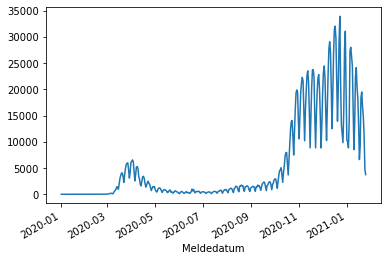

In [10]:
df.groupby(["Meldedatum"]).AnzahlFall.sum().plot()

## Preprocessing the Dataset for Time Series Analysis
src: 
https://github.com/abhiupes01/Multi_Step_Time_Series/blob/master/RNN_flight_passanger.ipynb

In [ ]:
# remove last 7 days - they are anyway unreliable
df = df[df["Meldedatum"] < df['Meldedatum'].max() - timedelta(days=7)]

In [ ]:
test_cutoff_date = df['Meldedatum'].max() - timedelta(days=28)
test_cutoff_date

In [ ]:
val_cutoff_date = test_cutoff_date - timedelta(days=28)
val_cutoff_date

In [ ]:
df_test = df[df['Meldedatum'] > test_cutoff_date]
df_val = df[(df['Meldedatum'] > val_cutoff_date) & (df['Meldedatum'] <= test_cutoff_date)]
df_train = df[df['Meldedatum'] <= val_cutoff_date]

#check out the datasets
print('Test dates: {} to {}'.format(df_test['Meldedatum'].min(), df_test['Meldedatum'].max()))
print('Validation dates: {} to {}'.format(df_val['Meldedatum'].min(), df_val['Meldedatum'].max()))
print('Train dates: {} to {}'.format(df_train['Meldedatum'].min(), df_train['Meldedatum'].max()))


## Transforming the Dataset for TensorFlow Keras

In [ ]:
complete = df['AnzahlFall'].values
train = df_train['AnzahlFall'].values
test = df_test['AnzahlFall'].values
val = df_val['AnzahlFall'].values


# Scaled to work with Neural networks.
scaler = MinMaxScaler(feature_range=(0, 1))
complete_scaled = scaler.fit_transform(complete.reshape(-1, 1)).reshape(-1, )
train_scaled = scaler.transform(train.reshape(-1, 1)).reshape(-1, )
test_scaled = scaler.transform(test.reshape(-1, 1)).reshape(-1, )
val_scaled = scaler.transform(val.reshape(-1, 1)).reshape(-1, )

In [ ]:
import matplotlib.pyplot as plt
plt.plot(train_scaled)
plt.show()

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers, Sequential

input_days = 30
output_days = 7
# Create the Keras model.
# Use hyperparameter optimization if you have the time.

#ts_inputs = tf.keras.Input(shape=(num_timesteps, 1))
# units=10 -> The cell and hidden states will be of dimension 10.
#             The number of parameters that need to be trained = 4*units*(units+2)
#x = layers.LSTM(units=10)(ts_inputs)
#x = layers.Dropout(0.2)(x)
#outputs = layers.Dense(1, activation='linear')(x)
#model = tf.keras.Model(inputs=ts_inputs, outputs=outputs)





#model = keras.Sequential()
#model.add(layers.LSTM(
#    input_shape=(input_days, 1),
#    return_sequences=True, units=1))
#model.add(layers.Dropout(0.2))
#model.add(layers.LSTM(
#    250,
#    return_sequences=True))
#model.add(layers.Dropout(0.2))
#model.add(layers.TimeDistributed(layers.Dense(1)))
#model.add(layers.Activation("linear"))
#model.compile(loss="mse", optimizer="rmsprop")

# define model
model = Sequential()
model.add(layers.LSTM(100, activation='relu', return_sequences=True, input_shape=(input_days, 1)))
model.add(layers.LSTM(100, activation='relu'))
model.add(layers.Dense(output_days))
model.compile(optimizer='adam', loss='mse')

In [ ]:
# Specify the training configuration.
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=['mse'])

In [ ]:
model.summary()

In [ ]:
# sample batch
batch_X = []
batch_Y = []
for y in range(0,1):
    batch_X.append(np.expand_dims(train_scaled[i:i+14], axis=1))
    batch_Y.append(train_scaled[i+14:i+(2*14)])
    i+=14
batch_X = np.array(batch_X)
batch_Y = np.array(batch_Y)

In [ ]:
batch_X

In [ ]:
batch_Y

In [ ]:
# Training
dataset = train_scaled
start = 0
end = len(dataset)
batch_size = 1
num_epochs = 100

for e in range(0,num_epochs):
    i = 0
    # train epochs in batches:
    while i+((input_days+output_days)*batch_size)<=end:
        batch_X = []
        batch_Y = []
        for y in range(0,batch_size):
            batch_X.append(np.expand_dims(dataset[i:i+input_days], axis=1))
            batch_Y.append(dataset[i+output_days:i+(2*output_days)])
            i+=input_days
        batch_X = np.array(batch_X)
        batch_Y = np.array(batch_Y)
        model.fit(x=batch_X, y=batch_Y, batch_size=16)

In [ ]:
X = np.expand_dims(np.expand_dims(complete_scaled[0:14], axis=1),axis=0)
np.squeeze(model.predict(X)[0])

In [ ]:
start = 0
end = len(complete_scaled)
predictions = []

i = 0
# predict one epoch:
while i+(input_days+output_days)<=end:
    X = np.expand_dims(np.expand_dims(complete_scaled[i:i+input_days], axis=1),axis=0)
    i+=output_days
    predictions.extend(np.squeeze(model.predict(X)[0]))

In [ ]:
len(predictions)

In [ ]:
len(complete_scaled)-7

In [ ]:
plt.plot(complete_scaled[input_days:],label="truth") # first seven days (0-6) were used as input for prediction
plt.plot(predictions[0:],label="predicted")
plt.show()

In [ ]:
# Let's test model with last 28 days (= test set)
dataset = test_scaled
start = 0
end = len(dataset)
input_days = 14

i = 0
while i+(input_days*batch_size)<=end:
    batch_X = []
    batch_Y = []
    for y in range(0,batch_size):
        batch_X.append(np.expand_dims(dataset[i:i+7], axis=1))
        batch_Y.append(dataset[i+7])
        i+=1
batch_X = np.array(batch_X)
batch_Y = np.array(batch_Y)
    
results = model.evaluate(batch_X, batch_Y, batch_size=batch_size)

In [ ]:
dataset = test_scaled
start = 0
end = len(dataset)
predictions = []
input_days = 14

i = 0
# predict one epoch:
while i+input_days<=end:
    X = np.expand_dims(np.expand_dims(dataset[i:i+14], axis=1),axis=0)
    i+=input_days
    predictions.extend(np.squeeze(model.predict(X)[0]))

In [ ]:
plt.plot(test_scaled[14:],label="truth") # first seven days (0-6) were used as input for prediction
plt.plot(predictions,label="predicted")
plt.show()